# Gaussian Regression of Light-Curves

This notebook explores the use of a Gaussian regression to fit CSP light curves. We use a modified version of the regression implimentation from the `avocado` package by [Kyle Boone](https://github.com/kboone).

#### Analysis steps considered by this notebook:

1. <a href='#gaussian_regression'>Gaussian Regression</a>: Fit observed light curves using a Gaussian regression
1. <a href='#err_relationship'>Measured and Regressed Error</a>: Examine the relationship between error values reported by CSP and the Gaussian regression


In [1]:
from warnings import warn

import numpy as np
import sncosmo
import sys
from astropy.table import Column, hstack, vstack
from astropy.table import Table
from copy import copy
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sndata.csp import DR3
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
import pandas as pd

sys.path.insert(0, '../')
from analysis import utils
from analysis import regression

dr3 = DR3()
dr3.download_module_data()
dr3.register_filters(force=True)
output_notebook()


Loading BokehJS ...

# Gaussian Regression <a id='gaussian_regression'></a>

We use Gaussian regression to fit the light curve in each band. These fits are then compared against a simultaneous fit performed using the Hsiao model.


In [2]:
def plot_regression(data, time, bands, pred_flux, pred_unc):
    """Plot regression results in flux space
    
    Plots data['flux'] and data['fluxerr'] vs time in each band.
    Plots pred_flux and pred_unc vs time in each band.
    
    Args:
        data            (Table): The measured photometric data
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertainty from the regression
    
    Returns:
        The figure object
        An array of figure axes
    """

    columns = 2
    rows = 5
    fig_shape = (rows, columns)
    fig_size = (3 * rows, 6 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size, sharey=True)
    for axis in axes[rows - 1]:
        axis.set_xlabel('Time')

    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')

    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        band_data = data[data['band'] == band_name]
        axis.scatter(band_data['time'], band_data['flux'], label=band_name)
        axis.errorbar(band_data['time'], band_data['flux'],
                      band_data['fluxerr'], linestyle='', label=None)

        axis.plot(time, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            time,
            f - fe,
            f + fe,
            alpha=.3,
            color='grey',
            label='Regression Error'
        )

        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.set_xlim(min(time), max(time))
        axis.legend()

    plt.tight_layout()
    return fig, axes


def subplot_sncosmo_flux(time, bands, fitted_model, axes):
    """Plot the predicted flux of an sncosmo in each band vs time
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = fitted_model.bandflux(band, time)

        except ValueError as e:
            print(f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass

        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


def subplot_sncosmo_mag(time, bands, fitted_model, axes):
    """Plot the predicted magnitude of an sncosmo in each band vs time
    
    Uses a zero point of 25.
    
    Args:
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Use existing axes
    """

    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = -2.5 * np.log10(fitted_model.bandflux(band, time)) + 25

        except ValueError as e:
            print(f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass

        else:
            axis.plot(time, band_flux, label=f'{fitted_model.source.name}')
            axis.legend()


First, we consider the fit in flux space.

In [3]:
def plot_dr3_object_flux(obj_id):
    """Plot the regression and Hsiao model fit for an object in flux space
    
    Args:
        obj_id (str): The Id of the object to plot
        
    Returns:
        The figure object
        An array of figure axes
    """

    data = dr3.get_data_for_id(obj_id)

    # Fit a gaussian regression
    gp = regression.fit_gaussian_process(data)
    bands = set(data['band'])
    time = np.arange(min(data['time']) - 1, max(data['time']) + 1)
    gp_flux, gp_unc = regression.predict_light_curve(gp, bands, time)
    fig, axes = plot_regression(data, time, bands, gp_flux, gp_unc)
    axes[0, 0].set_ylim(0)
    fig.suptitle(obj_id, fontsize=30, y=1.05)
    
    # Plot modeled flux
    sncosmo_model = sncosmo.Model('hsiao')
    sncosmo_model.set(z=data.meta['z'])
    sncosmo_model.set(t0=utils.get_csp_t0(obj_id))
    fit_result, fitted_model = sncosmo.fit_lc(data, sncosmo_model, ['amplitude'])
    subplot_sncosmo_flux(time, bands, fitted_model, axes)

    return fig, axes


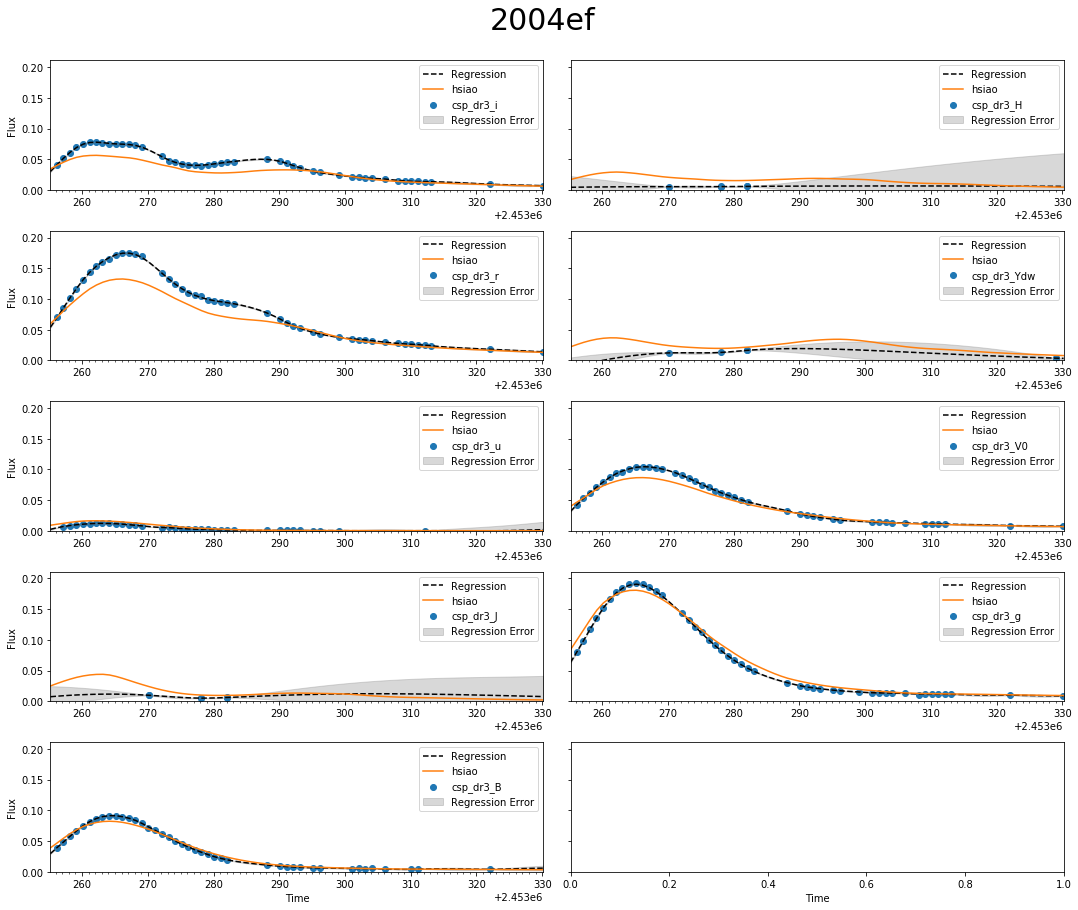

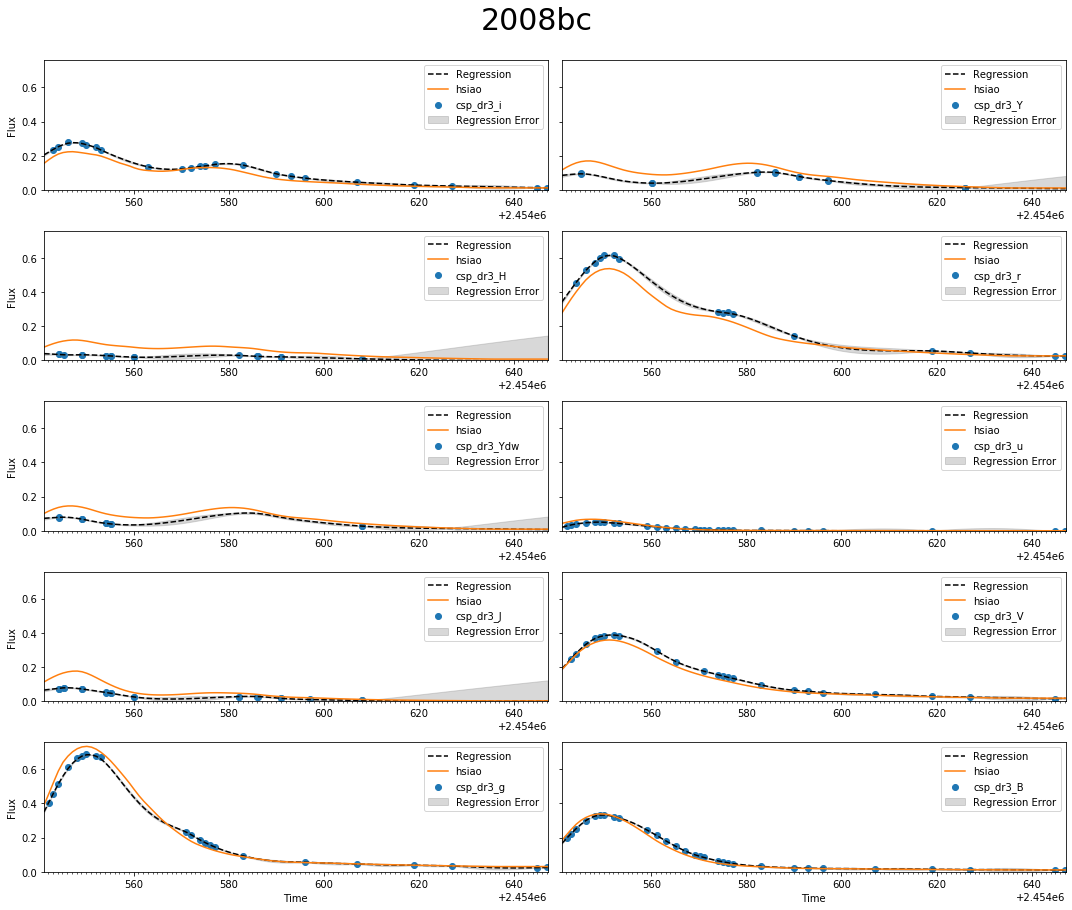

In [4]:
_ = plot_dr3_object_flux('2004ef')
_ = plot_dr3_object_flux('2008bc')


Next we consider the fit in terms of magnitudes.

In [5]:
def plot_dr3_object_mag(obj_id):
    """Plot the regression and Hsiao model fit for an object in magnitude space
    
    Args:
        obj_id (str): The Id of the object to plot
        
    Returns:
        The figure object
        An array of figure axes
    """

    data = dr3.get_data_for_id(obj_id)
    mag_data = data.copy()
    mag_data['flux'] = -2.5 * np.log10(mag_data['flux']) + 25
    mag_data['fluxerr'] = (-2.5 * mag_data['fluxerr']) / (mag_data['flux'] * np.log(10))

    # Fit a gaussian regression
    gp = regression.fit_gaussian_process(data)
    bands = set(mag_data['band'])
    time = np.arange(min(mag_data['time']) - 1, max(mag_data['time']) + 1)
    gp_flux, gp_unc = regression.predict_light_curve(gp, bands, time)
    fig, axes = plot_regression(mag_data, time, bands, gp_flux, gp_unc)
    fig.suptitle(obj_id, fontsize=30, y=1.05)
    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Magnitude')
    
     # Fit hsiao
    sncosmo_model = sncosmo.Model('hsiao')
    sncosmo_model.set(z=data.meta['z'])
    sncosmo_model.set(t0=utils.get_csp_t0(obj_id))
    fit_result, fitted_model = sncosmo.fit_lc(data, sncosmo_model, ['amplitude'])
    subplot_sncosmo_mag(time, bands, fitted_model, axes)

    return fig, axes


In [ ]:
_ = plot_dr3_object_mag('2004ef')
_ = plot_dr3_object_mag('2008bc')


Although the Gaussian regression performs well within the observed time range, Gaussian regressions are generally bad at extrapolating. For this reason, we choose to limit our use of the above regression when predicting flux values to within the first and last observed data point in each band. 

The regression also tends to drift towards zero at late times when the photometric sampling is low. This results in a non-physical jump in the estimated magnitude.

## Measured and Regressed Errors <a id='err_relationship'></a>

We begin by comparing error values published by CSP against those returned by our implementation of a Gaussian regression. We do this for all SNe included in the CSP DR3 data release.



In [ ]:
def create_regression_table(data_table, **kwargs):
    """Fit photometric observations with a gaussian regression
    
    This function is a wrapper combining the ``fit_gaussian_process``
    and ``predict_light_curve`` functions from the ``regression`` module.

    Args:
        data (Table): Data table from sndata (format_sncosmo=True)
        

    Returns:
        An astropy table with measured data and regression results
    """

    # Regress light curve and return fitted flux
    bands = set(data_table['band'])
    times = [data_table[data_table['band'] == band]['time'] for band in bands]
    gp = regression.fit_gaussian_process(data_table, **kwargs)
    flux, flux_err = regression.predict_light_curve(gp, bands, times)

    pred_tables = []
    for b, t, f, fe in zip(bands, times, flux, flux_err):
        table_this = Table([t, f, fe], names=['time', 'reg_flux', 'reg_fluxerr'])
        table_this['band'] = Column(b, dtype=object, length=len(table_this))
        pred_tables.append(table_this)

    # Use hstack instead of join since there are duplicate band / time combos
    data_table = copy(data_table)
    data_table.sort(['band', 'time'])
    prediction = vstack(pred_tables)
    prediction.sort(['band', 'time'])
    prediction.remove_columns(['band', 'time'])
    out_table = hstack([data_table, prediction])

    out_table['obj_id'] = data_table.meta['obj_id']
    out_table['residuals'] = out_table['flux'] - out_table['reg_flux']
    return out_table


def plot_reg_errors(flux, flux_err, reg_err):
    """Plot regressed vs published error values 
    
    Args:
        reg_results (Table): A table from ``create_regression_table``
        
    Returns:
        The figure object
        An array of figure axes
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    plot_combos = (
        (flux, flux_err),
        (flux, reg_err),
        (flux_err, reg_err)
    )

    for (x, y), axis in zip(plot_combos, axes):
        axis.scatter(x, y, label=None)

        fit_params = np.polyfit(x, y, 1)
        fit_func = np.poly1d(fit_params)
        axis.plot(
            x, fit_func(x),
            label=f'{fit_params[0]:0.2}x + {fit_params[1]:0.2}',
            color='black'
        )

        axis.set_xlim(min(x), max(x))
        axis.set_ylim(min(y), max(y))
        axis.legend()

    axes[0].set_xlabel(f'Published Flux')
    axes[0].set_ylabel(f'Published Error')
    axes[1].set_xlabel(f'Published Flux')
    axes[1].set_ylabel(f'Regression Error')
    axes[2].set_xlabel(f'Published Error')
    axes[2].set_ylabel(f'Regression Error')

    axes[2].plot([-1, 1], [-1, 1], color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

    return fig, axes


In [ ]:
all_targets = vstack(
    [create_regression_table(data_table) for data_table in dr3.iter_data(verbose=True)],
    metadata_conflicts='silent'
)


In [ ]:
fig, axes = plot_reg_errors(all_targets['flux'], all_targets['fluxerr'], all_targets['reg_fluxerr'])
fig.suptitle('All CSP DR1 Targets')
plt.show()


We note that the regression errors are about 60% the size of the published errors and are always smaller. However, this plot is misleading as the relationship in the right-most sub plot is not actually linear. When we inspect the results of a single object, we see that the trend is much more like a negative exponential.

In [ ]:
def legend_without_duplicate_labels(ax, **kwargs):
    """Create a figure label with no duplicates:
    
    Args:
        ax (axis): The axis to add the lagend to
        Any other kwargs for ax.legend
    """
    
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), **kwargs)
    
    
def plot_fitted_errors_for_object(obj_id, scale_by='all', figsize=(6, 6)):
    """Plot fits of regressed vs published error for a single object
    
    Args:
        obj_id   (str): A CSP DR3 object ID for the data to plot
        scale_by (str): Fit regressed error collectively ("all") or by band ("band")
        figsize (tuple): The size of the figure
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    # Perform a gaussian regression on the data
    data = dr3.get_data_for_id(obj_id)
    reg_results = create_regression_table(data, fix_scale=False)
    reg_results.sort('fluxerr')
    x = reg_results['fluxerr']
    y = reg_results['reg_fluxerr']

    # setup figure
    fig, axes = plt.subplots(
        2, 1,
        figsize=figsize,
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True)

    # Scale the error using a negative exponential
    if scale_by == 'all':
        scaled_errors, exp_opt, exp_cov = regression.scale_errors(x, y)
        exp_yvals = regression.neg_exponential(x, *exp_opt)
        axes[0].plot(x, exp_yvals, color='k', zorder=100)

    # Plot the errors in each band
    max_residual = 0
    for band in set(reg_results['band']):
        indices = np.where(reg_results['band'] == band)[0]
        band_x, band_y = x[indices], y[indices]
        axes[0].scatter(band_x, band_y, s=10, label=band.split('_')[-1])

        if scale_by == 'band':
            band_scaled_errors, exp_opt, exp_cov = regression.scale_errors(band_x, band_y)
            exp_yvals = regression.neg_exponential(x, *exp_opt)
            axes[0].plot(x, exp_yvals, alpha=.5)

        residuals = (band_y - regression.neg_exponential(band_x, *exp_opt)) 
        axes[1].scatter(band_x, residuals, s=10)
        max_residual = max(max_residual, max(np.abs(residuals)))
        
    
    limit = max(max(x), max(y))
    axes[0].plot([0, limit], [0, limit], label=None, linestyle='--', color='k')
    axes[0].set_xlim(0, limit)
    axes[0].set_ylim(0, limit)
    axes[0].set_ylabel(f'Regression Error')
    axes[0].set_title(obj_id)
    axes[1].axhline(0, linestyle=':', color='k', zorder=0)
    axes[1].set_xlabel(f'Published Error')
    axes[1].set_ylabel('Residuals')
    axes[1].set_ylim(- 1.1 * max_residual, 1.1 * max_residual)
    plt.subplots_adjust(hspace=0)
    legend_without_duplicate_labels(axes[0])

    return fig, axes


In [ ]:
plot_fitted_errors_for_object('2005kc')
plot_fitted_errors_for_object('2005kc', 'band')
plot_fitted_errors_for_object('2004ef')
plot_fitted_errors_for_object('2004ef', 'band')
plot_fitted_errors_for_object('2004dt')
plot_fitted_errors_for_object('2004dt', 'band')


In [ ]:
def plot_scaled_errors_for_csp(figsize=(6, 6)):
    """Plot the rescaled regression error vs measured error for all CSPDR3
    
    Args:
        figsize (tuple): The size of the figure
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    fig, axes = plt.subplots(
    2, 1,
    figsize=figsize,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True)

    max_residual = 0
    for data_table in dr3.iter_data(verbose=0):
        regression_table = create_regression_table(data_table)

        for band_data in regression_table.group_by('band').groups:
            x = band_data['fluxerr']
            y = band_data['reg_fluxerr']
            band = band_data['band'][0]
            band_label = band.split('_')[-1]
            band_color = f'C{dr3.band_names.index(band)}'

            try:
                band_scaled_errors, exp_opt, exp_cov = regression.scale_errors(x, y)

            except TypeError:
                # warn(f'Insufficient data to constrain fit {data_table.meta["obj_id"]} {band}')
                continue

            except RuntimeError:
                # warn(f'Failed fit for {data_table.meta["obj_id"]} {band}')
                continue

            residuals = (x - band_scaled_errors)
            max_residual = max(max_residual, max(np.abs(residuals)))
            axes[0].scatter(x, band_scaled_errors, s=10, color=band_color, label=band_label)
            axes[1].scatter(x, residuals, s=10, color=band_color)

    axes[0].plot([-1, 100], [-1, 100], linestyle='--', color='k')
    axes[0].set_ylabel(f'Regression Error')
    axes[0].set_xlim(0, .08)
    axes[0].set_ylim(0, .08)

    axes[1].axhline(0, linestyle=':', color='k', zorder=0)
    axes[1].set_xlabel(f'Published Error')
    axes[1].set_ylabel('Residuals')
    axes[1].set_ylim(- 1.1 * max_residual, 1.1 * max_residual)
    plt.subplots_adjust(hspace=0)
    legend_without_duplicate_labels(axes[0], loc='lower right', framealpha=1)
    return fig, axes


In [ ]:
_ = plot_scaled_errors_for_csp()


To investigate any outliers, we create an interactive version of the above plot.

In [ ]:
def bokeh_scaled_errors_for_csp():
    """Plot resampled error vs published error with bokeh
    
    Args:
        figsize (tuple): The size of the figure
        
    Returns:
        A bokeh figure
    """

    tooltips = [
        ('obj_id', '@obj_id'),
        ('obs_err', '@obs_err'),
        ('reg_err', '@reg_err'),
        ('band', '@band'),
        ('time', '@jd')
    ]
    p = figure(plot_width=400, plot_height=400, tooltips=tooltips)
    
    plot_data = {'obs_err': [], 'reg_err': [], 'obj_id': [], 'band': [], 'jd': []}
    for data_table in dr3.iter_data(verbose=0):
        obj_id = data_table.meta['obj_id']
        regression_table = create_regression_table(data_table)

        for band_data in regression_table.group_by('band').groups:
            x = band_data['fluxerr']
            y = band_data['reg_fluxerr']
            band = band_data['band'][0]
            band_label = band.split('_')[-1]

            try:
                band_scaled_errors, exp_opt, exp_cov = regression.scale_errors(x, y)

            except TypeError:
                # warn(f'Insufficient data to constrain fit {data_table.meta["obj_id"]} {band}')
                continue

            except RuntimeError:
                # warn(f'Failed fit for {data_table.meta["obj_id"]} {band}')
                continue

            plot_data['obs_err'].extend(x)
            plot_data['reg_err'].extend(band_scaled_errors)
            plot_data['obj_id'].extend([obj_id for _ in x])
            plot_data['band'].extend([band_label for _ in x])
            plot_data['jd'].extend(band_data['time'] - 2.454e6)
            
    
    plot_df = pd.DataFrame(plot_data)
    source = ColumnDataSource(data=plot_df)
    p.circle('obs_err', 'reg_err', source=source, size=5, alpha=0.5)
    return p


In [ ]:
show(bokeh_scaled_errors_for_csp())


In [ ]:
plot_fitted_errors_for_object('2008J', 'band')
plot_dr3_object_flux('2008J')


In [ ]:
plot_fitted_errors_for_object('2005gj', 'band')
plot_dr3_object_flux('2005gj')
